# yolov4_crowdhuman

This notebook demenstartes how to train a "yolov4-crowdhuman-416x416" model using *GPU* on Google Colab.

![A sample picture in the CrowdHuman dataset](https://raw.githubusercontent.com/jkjung-avt/yolov4_crowdhuman/master/doc/crowdhuman_sample.jpg)

Note that *GPU* resource on Google Colab is free, but *neither unlimited nor guaranteed*.  Please read the relevant section of the official FAQ before you proceed.  In short, if you use too much, your access could be locked out for a certain period of time.

* https://research.google.com/colaboratory/faq.html#resource-limits

Otherwise, this notebook is used to train a "yolov4-crowdhuman-416x416" model which detects 2 classes of objects: "head" and "person".  Please refer to the following GitHub repository and blog post for more details about the training:

* [jkjung-avt/yolov4_crowdhuman](https://github.com/jkjung-avt/yolov4_crowdhuman)
* [My blog post: to be updated...](https://jkjung-avt.github.io/)

This notebook saves training log, loss/mAP chart, and trained weights onto your Google Drive.  So please **make sure your Google Drive has been mounted onto the Colab runtime**.  You could verify it by checking whether the "drive" directory is present in the "Files" tab on the left, as shown in the picture below.  (Click the "Mount Drive" icon if necessaey.)  Also make sure there is **at least 2GB of disk space available on your Google Drive** for saving those files.

<center><img src="https://raw.githubusercontent.com/jkjung-avt/yolov4_crowdhuman/master/doc/drive_on_colab.jpg" alt="Google Drive mounted on Colab" width="600"/></center>

This notebook has been set to use "GPU", so it should automatically connect to a GPU runtime on Google Colab when run.

**Global Settings**

In [ ]:
# Name of the directory on Google Drive for saving training log, loss/mAP chart,
# and weights
SAVE_DIR = 'yolov4_crowdhuman'

# Path of the Google Drive mount point
DRIVE_DIR = '/content/drive/My Drive'

# Full path to the save directory on Google Drive
DRIVE_SAVE_DIR = DRIVE_DIR + '/' + SAVE_DIR

# Input shape {width}*{height} of the yolov4 model to be trained
INPUT_SHAPE = '416x416'

Check and make sure Google Drive has been mounted before proceeding.

In [ ]:
from pathlib import Path
assert Path(DRIVE_DIR).is_dir(), 'Google Drive has not been mounted?'

**GPU Runtime**

Let's do a quick check which GPU has been allocated.

According to [Google Colab FAQ](https://research.google.com/colaboratory/faq.html#gpu-availability), "the GPUs available in Colab often include Nvidia K80s, T4s, P4s and P100s."  You should look for the "Name" field in nvidia-smi output below to see which GPU is used for this session.

In [ ]:
!nvidia-smi

Wed Sep  2 13:42:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Step-by-step**

The training process has been broken down into small steps below.  This way, you could easily check and fix an issue when it occurs.  And here's a word of caution before you start:  **Do not run this same (unmodified) notebook on 2 or more browser sessions simultaneously.**  Since the training processes would write training log and mAP/loss chart to the same files on your Google Drive, the results would be very confusing if you do that...

**Step 1**

Clone "yolov4_crowdhuman" source code from GitHub.

In [ ]:
%cd /content
if not Path('yolov4_crowdhuman').is_dir():
    !git clone https://github.com/jkjung-avt/yolov4_crowdhuman.git

/content
Cloning into 'yolov4_crowdhuman'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 147 (delta 81), reused 101 (delta 39), pack-reused 0
Receiving objects: 100% (147/147), 133.83 KiB | 851.00 KiB/s, done.
Resolving deltas: 100% (81/81), done.


**Step 2**

Run the "prepare_rawdata.sh" script in the "data/" subdirectory.  It would download CrowdHuman dataset and unzip all train/val image files.  You could refer to [jkjung-avt/yolov4_crowdhuman](https://github.com/jkjung-avt/yolov4_crowdhuman) for more information.

This step could take 20~30 minutes.  (TODO: Consider to delete the zip files in /content/yolov4_crowdhuman/data/raw to save storage space on the Colab runtime?)

In [ ]:
%cd /content/yolov4_crowdhuman/data
!./prepare_rawdata.sh {INPUT_SHAPE}

Streaming output truncated to the last 5000 lines.
  inflating: Images/284193,23f0005477e99d.jpg  
  inflating: Images/284193,249290002dd88361.jpg  
  inflating: Images/284193,2493f000c4ca2d08.jpg  
  inflating: Images/284193,2498a0009a96b261.jpg  
  inflating: Images/284193,249b50007f5b0ea6.jpg  
  inflating: Images/284193,255340008725276d.jpg  
  inflating: Images/284193,2554b000639e7013.jpg  
  inflating: Images/284193,2558b0000791fbd7.jpg  
  inflating: Images/284193,255cc0007eb00114.jpg  
  inflating: Images/284193,25607000c04c865c.jpg  
  inflating: Images/284193,256190008452b742.jpg  
  inflating: Images/284193,25661000adab832a.jpg  
  inflating: Images/284193,2571f00078428ccb.jpg  
  inflating: Images/284193,2573500042c4fa37.jpg  
  inflating: Images/284193,2574a0007e589d4c.jpg  
  inflating: Images/284193,25778000d60792c9.jpg  
  inflating: Images/284193,257870001d9bc149.jpg  
  inflating: Images/284193,2581a000de8a21f9.jpg  
  inflating: Images/284193,258270009ea5c6b2.jpg  
 

**Step 3**

Convert CrowdHuman annotation files into YOLO txt format.

In [ ]:
%cd /content/yolov4_crowdhuman/data
%run gen_txts.py {INPUT_SHAPE}

Streaming output truncated to the last 5000 lines.
Processing ID: 283647,1644d000ec93d8b4
Processing ID: 282555,11095e0000a0154f9
Processing ID: 282555,19ec300061bfd9e9
Processing ID: 273278,3dde4000263464b7
Processing ID: 282555,1200670007d50295b
Processing ID: 284193,1cc57000009322d5
Processing ID: 273278,c6eda0007fb9380f
Processing ID: 282555,33ff100035776f08
Processing ID: 273275,921ab0003e5e0914
Processing ID: 273275,6aeaa0005bd1ebea
Processing ID: 282555,1215c0000c2b2adb2
Processing ID: 282555,bbf810006c43fac8
Processing ID: 273278,b5d16000011d18a1
Processing ID: 273278,76f8900018333c49
Processing ID: 282555,12714000968539fa
Processing ID: 283647,241d00004ecfc04
Processing ID: 283554,3cc1100077b38ce8
Processing ID: 273278,13ff51000fa0db26a
Processing ID: 284193,25cd8000f3200193
Processing ID: 273278,d1624000c82ca0e7
Processing ID: 273278,13b0ba0009329d1c9
Processing ID: 283992,2f8f000e7134e70
Processing ID: 283081,40300051c350e8
Processing ID: 273278,2ecda000634a8974
Processing I

**Step 4**

Check out "darknet" source code from GitHub.

In [ ]:
%cd /content/yolov4_crowdhuman
!rm -rf darknet
!git clone https://github.com/AlexeyAB/darknet.git

/content/yolov4_crowdhuman
Cloning into 'darknet'...
remote: Enumerating objects: 14285, done.
remote: Total 14285 (delta 0), reused 0 (delta 0), pack-reused 14285
Receiving objects: 100% (14285/14285), 12.84 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (9748/9748), done.


**Step 5**

Patch darknet source code and build executable.  Note the following CUDA arch settings in the patch:

* "37": Tesla K80
* "60": Tesla P100
* "61": Tesla P4
* "75": Tesla T4

In [ ]:
%cd /content/yolov4_crowdhuman/darknet
!sed -i "1s/GPU=0/GPU=1/"               Makefile
!sed -i "2s/CUDNN=0/CUDNN=1/"           Makefile
!sed -i "3s/CUDNN_HALF=0/CUDNN_HALF=1/" Makefile
!sed -i "4s/OPENCV=0/OPENCV=1/"         Makefile
!sed -i "5s/AVX=0/AVX=1/"               Makefile
!sed -i "7s/LIBSO=0/LIBSO=1/"           Makefile
!sed -i "20s/compute_30,code=sm_30 \\\/compute_37,code=sm_37 -gencode arch=compute_60,code=[sm_60,compute_60] -gencode arch=compute_61,code=[sm_61,compute_61] -gencode arch=compute_75,code=[sm_75,compute_75]/" Makefile
!sed -i "21s/^/#/"                      Makefile
!sed -i "22s/^/#/"                      Makefile
!sed -i "23s/^/#/"                      Makefile
!sed -i "24s/^/#/"                      Makefile
# Let darknet test mAP more frequently during training 
!sed -i "300s/calc_map_for_each = 4/calc_map_for_each = 1/" src/detector.c

!make

/content/yolov4_crowdhuman/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -ffp-contract=fast -mavx -mavx2 -msse3 -msse4.1 -msse4.2 -msse4a -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warn

**Step 6**

Create folders and symlinks for saving training log and results.

In [ ]:
!mkdir -p "{DRIVE_SAVE_DIR}"
!rm -f "{DRIVE_SAVE_DIR}"/train.log
!touch "{DRIVE_SAVE_DIR}"/chart.png
!rm -f chart.png
!ln -sf "{DRIVE_SAVE_DIR}"/chart.png .
!mkdir -p "{DRIVE_SAVE_DIR}"/backup
!rm -rf backup
!ln -sf "{DRIVE_SAVE_DIR}"/backup .

**Step 7**

Set up all remaining files needed for training the model.  The pre-trained yolov4 weights file ("yolov4.conv.137") is also downloaded here.

In [ ]:
%cd /content/yolov4_crowdhuman
!./prepare_training.sh {INPUT_SHAPE}

/content/yolov4_crowdhuman
** Install requirements
** Copy files for training
** Download pre-trained yolov4 weights
Downloading...
From: https://drive.google.com/uc?id=1JKF-bdIklxOOVy-2Cr5qdvjgGpmGfcbp
To: /content/yolov4_crowdhuman/darknet/yolov4.conv.137
170MB [00:00, 205MB/s]
** Done.


**Step 9**

Start training!  The total number of training iterations is 5,000.  It could take more than 3 hours to finish.

Training progress could be checked by looking at the following files on your Google Drive:

   ```
   yolov4_crowdhuman/train.log
   yolov4_crowdhuman/chart.png
   ```

In [ ]:
%cd /content/yolov4_crowdhuman/darknet
!./darknet detector train data/crowdhuman-{INPUT_SHAPE}.data cfg/yolov4-crowdhuman-{INPUT_SHAPE}.cfg yolov4.conv.137 -gpu 0 -map -dont_show 2>&1 | tee "{DRIVE_SAVE_DIR}"/train.log | grep -E "hours left|mean_average"

Streaming output truncated to the last 5000 lines.
 10: 1945.043457, 1943.348389 avg loss, 0.000000 rate, 3.493323 seconds, 240 images, 4.750264 hours left
 11: 1225.125366, 1871.526123 avg loss, 0.000000 rate, 2.275884 seconds, 264 images, 4.751184 hours left
 12: 1216.303101, 1806.003784 avg loss, 0.000000 rate, 2.129476 seconds, 288 images, 4.745126 hours left
 13: 1216.108521, 1747.014282 avg loss, 0.000000 rate, 1.897071 seconds, 312 images, 4.727180 hours left
 14: 1215.030762, 1693.815918 avg loss, 0.000000 rate, 2.832854 seconds, 336 images, 4.706190 hours left
 15: 1221.584839, 1646.592773 avg loss, 0.000000 rate, 2.265407 seconds, 360 images, 4.698364 hours left
 16: 1217.703125, 1603.703857 avg loss, 0.000000 rate, 2.293240 seconds, 384 images, 4.682750 hours left
 17: 1218.371948, 1565.170654 avg loss, 0.000000 rate, 2.492771 seconds, 408 images, 4.667672 hours left
 18: 1219.460327, 1530.599609 avg loss, 0.000000 rate, 2.945154 seconds, 432 images, 4.655501 hours left
 19:

**Step 10**

The trained "yolov4-crowdhuman-416x416" model (weights) is saved in the "yolov4_crowdhuman/backup/" directory on your Google Drive.

Let's test the "final" trained model.

In [ ]:
!./darknet detector test data/crowdhuman-{INPUT_SHAPE}.data cfg/yolov4-crowdhuman-{INPUT_SHAPE}.cfg backup/yolov4-crowdhuman-{INPUT_SHAPE}_final.weights data/crowdhuman-{INPUT_SHAPE}/273275,4e9d1000623d182f.jpg -gpu 0 -dont_show

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  

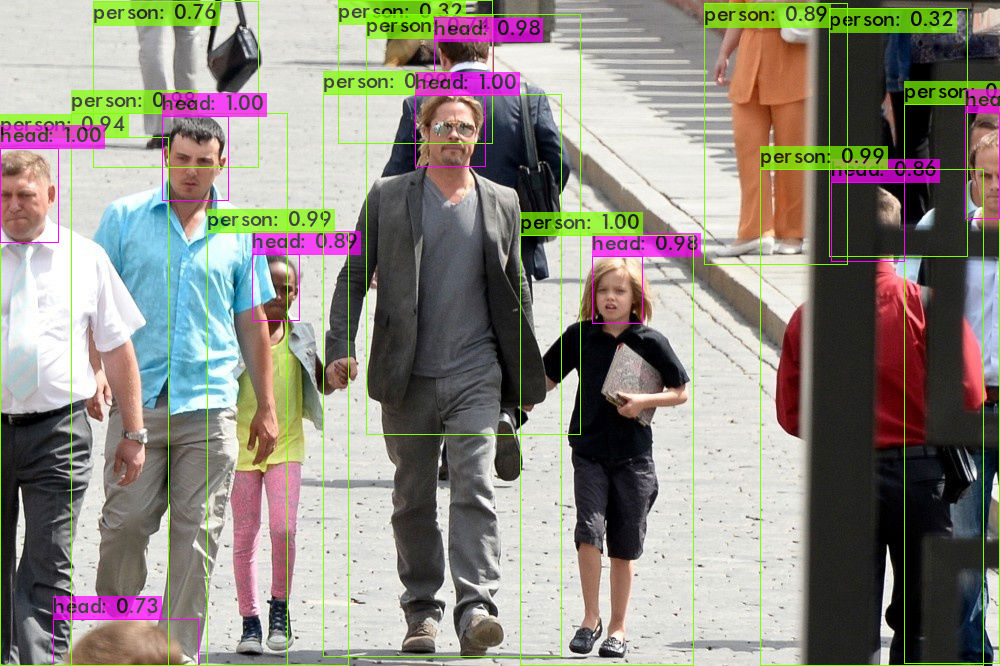

In [ ]:
from IPython.display import Image
Image('predictions.jpg')

**Step 11**

Just for reference, I got a "yolov4-crowdhuman-416x416" model with mAP ~0.658.  Here's the loss/mAP chart.

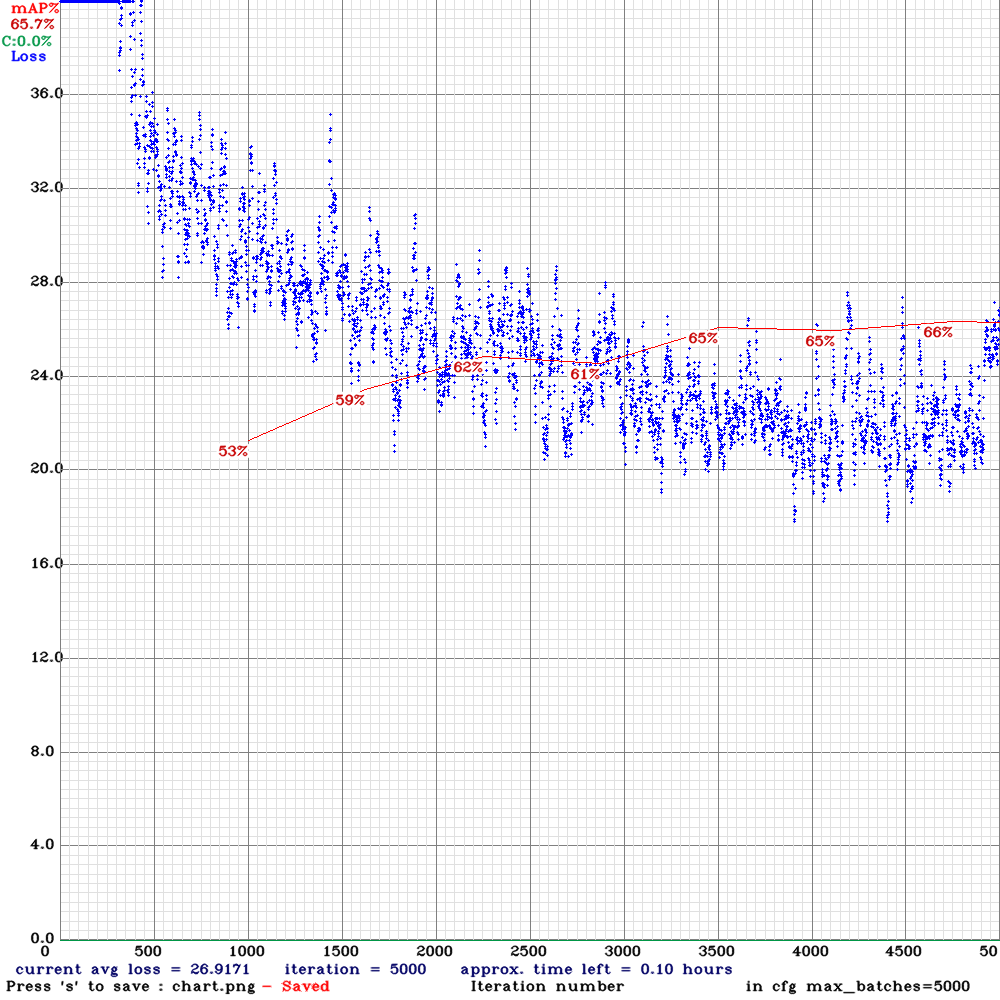

In [12]:
Image('chart.png')

All done. If possible, terminate the GPU session manually (for keeping a good record on Google Colab :-).